# Calculating the correlation coefficient between the Nino3.4 index and the model's velocity potential

## 1. Load modules

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

## 2. Read index data

In [2]:
# Read index
df = pd.read_csv('nina34.anom.data', sep=r'\s+', header=None)
df.columns = ['years'] + [f'{month}' for month in range(1, 13)]
# df

In [3]:
years = np.arange(1980,2015)
nyr = len(years)
nino34_Jan = df['1'][(df['years'] >= 1980) & (df['years'] <= 2014)]

## 3. Define a new function

In [4]:
def intp(data_h,lat_l,lon_l):
    low_res = data_h.interp(lat=lat_l, lon=lon_l, method='linear')
    return low_res

def get_anomaly(fname,idir):
    ds = xr.open_dataset(fname)
    lat = ds['lat'].sel(lat=slice(-30,30))
    lon = ds['lon']
    nlat = len(lat)
    nlon = len(lon)

    time = ds['time']
    ntime = len(time)
    vp_array = np.empty((nyr,ntime,nlat,nlon),dtype=np.float32)
    for n, year in enumerate(years):
        vp_path = idir+f'vp200_{year}01.nc'
        ds_vp = xr.open_dataset(vp_path)
        vp_array[n,:,:,:] = ds_vp['vp200'].sel(lat=slice(-30, 30))
    vp_array = xr.DataArray(vp_array,dims=['years','time','lat','lon'],
                           coords={'years': years,
                                  'time': time,
                                  'lat': lat,
                                  'lon': lon}, name = 'vp')
    vp_clim = vp_array.mean('years')
    vp_ano = vp_array - vp_clim
    vp_ano = xr.DataArray(vp_ano,dims=['years','time','lat','lon'],
                           coords={'years': years,
                                  'time': time,
                                  'lat': lat,
                                  'lon': lon}, name = 'vp')
    
    return vp_ano

## 4. Read model data

In [5]:
# velocity potential data
idir_m = '/scratch/jjung45/mjo/vp200/'
fname_m = idir_m + 'vp200_200801.nc' #float prate(ens,time,lat,lon); mm/day
 
idir_e = '~/_scratch/ERA5/daily/vp200/'
fname_e = idir_e + 'vp200_200801.nc'

In [6]:
vp_ano_m = get_anomaly(fname_m,idir_m)
vp_ano_e = get_anomaly(fname_e,idir_e)

#### Adjust the horizontal resolution between models

In [7]:
lat_m = vp_ano_m[0]['lat']
lon_m = vp_ano_m[0]['lon']

nlat = len(lat_m)
nlon = len(lon_m)
vp_ano_e_intp = np.empty((nyr,nlat,nlon),dtype=np.float32)
for i in range(len(years)):
    raw_data = vp_ano_e[i,:,:,:].mean(dim="time")
    intp_data = intp(raw_data,lat_m,lon_m)
    vp_ano_e_intp[i,:,:] = intp_data

In [8]:
vp_yr_m = vp_ano_m[:,:31,:,:].mean(dim="time")
vp_yr_e = vp_ano_e_intp

## 5. Calculate the correlation coefficient

In [9]:
# Load additional required modules
from scipy.stats import pearsonr

In [10]:
nx=len(lon_m)
ny=len(lat_m)

p_array_m=np.zeros((ny,nx))
r_array_m=np.zeros((ny,nx))

p_array_e=np.zeros((ny,nx))
r_array_e=np.zeros((ny,nx))

for i in range(nx):
    for j in range(ny):
        r_m,p_m = pearsonr(nino34_Jan,vp_yr_m[:,j,i])
        r_array_m[j,i] = r_m
        p_array_m[j,i] = p_m
        r_e,p_e = pearsonr(nino34_Jan,vp_yr_e[:,j,i])
        r_array_e[j,i] = r_e
        p_array_e[j,i] = p_e

r_array = [r_array_e,r_array_m]

In [11]:
mask_sig_m = np.where(p_array_m<0.05,r_array_m,np.nan)
mask_sig_e = np.where(p_array_e<0.05,r_array_e,np.nan)
mask_sig = [mask_sig_e, mask_sig_m]

## 6. Plot the calculated correlation coefficients on a map

In [12]:
def set_latlon(ax,ln_l,ln_r,ln_iv,lt_b,lt_u,lt_iv):
    # longitude label
    ax.set_xticks(np.arange(ln_l,ln_r+1,ln_iv), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    # latitude label
    ax.set_yticks(np.arange(lt_b,lt_u+1,lt_iv), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    # gridline
    gl = ax.gridlines(ylocs=np.arange(lt_b,lt_u+1,lt_iv),draw_labels=False, 
                      linestyle='--',linewidth=0.6, color='gray', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False


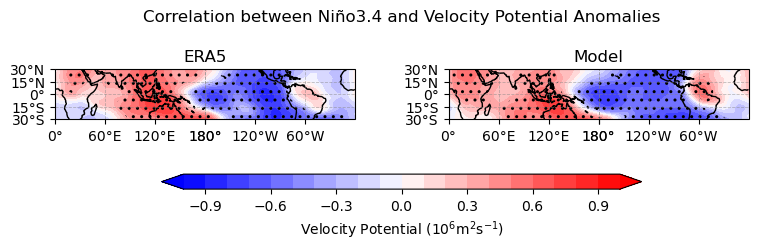

In [13]:
labels=['ERA5','Model']
clevs = np.arange(-1,1.1,0.1)
hatch_levs=[0]

# Define the figure and each axis for the 1 rows and 3 columns
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
                        figsize=(8,10))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array (just 3 rows)
axs = axs.flatten()

#Loop over all of the cases and plot
for i in range(2): #,enso in enumerate(r_array):

        # Select the case
        data = r_array[i]

        # Add the cyclic point
        data,lons = add_cyclic_point(data,coord=lon_m)
        mask_data,lons=add_cyclic_point(mask_sig[i],coord=lon_m)

        # Contour plot
        cs=axs[i].contourf(lons,lat_m,data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='bwr',extend='both')
        ss=axs[i].contourf(lons,lat_m,mask_data,[0,1],
                transform = ccrs.PlateCarree(),colors=['None'],
                hatches=['..','..'],extend='both',alpha=0.0)

        # To set lat, lon axis
        set_latlon(axs[i],-180,180,60,-30,30,15)

        # Title each subplot with the name of the season
        axs[i].set_title(labels[i])

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.85, top=0.9, left=0.04, right=0.96,
                    wspace=0.15, hspace=0)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.78, 0.6, 0.015])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal'
                    ,label="Velocity Potential ($10^6$m$^2$s$^{-1}$)")

plt.suptitle('Correlation between Niño3.4 and Velocity Potential Anomalies',y=0.96)
plt.savefig('plot_map_corr_bw_nino34_models.png',dpi=300,bbox_inches="tight", pad_inches=0.1)